## League of Legends Churn Prediction [Feature Engineering and Modeling] - Ben Pacheco

In the previous notebook I performed EDA and wrangling to create a master dataset. Now I will feature engineer some important variables I think will have an impact on model performance, then run my models to see how they perform by default, and finally tune them using hyperparameters to control the learning process of our models.

### Preface

#### What steps to take before modeling?
* Feature engineer variables to enhance model and create prediction feature "churn"
* Remove features that are not needed to fit model
* One hot encode categorical features

#### What models to use?
* Logistic Regression
* Random Forest
* XGBoost

#### Hyperparameter Tuning
* Gridsearch Cross Validation
* Tree-Parzen Estimator Algorithm

#### Insights
* Feature Importance
* SHAP Values
* Partial Dependency Plots

In [3]:
#importing packages
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
import math
from datetime import datetime
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import (accuracy_score, f1_score, recall_score, precision_score)
from sklearn.inspection import PartialDependenceDisplay
import pickle as pickle
import optuna
import shap
import re
import warnings
warnings.filterwarnings("ignore")


In [4]:
#display all columns/rows
#set seed so resutls are always same
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
seed = np.random.seed(42)

### Feature Engineering

In [5]:
#load dataframe
df = pd.read_csv('../data/processed/master_lol_churn_prediction.csv')
df.head()

,summoner_name,league_points,rank,wins,losses,veteran,fresh_blood,hot_streak,tier,match_id,game_end_timestamp,game_start_timestamp,game_version,assists,kills,deaths,lane,champion_name,gold_earned,turret_kills,total_dmg_dealt,total_heal,vision_score,summoner_level,time_played,last_match
0,Soundwave2017,0,I,3,11,False,False,False,IRON,NA1_4306888010,2022-05-14 03:48:50,2022-05-14 03:07:53,12.9.439.127,14,6,8,BOTTOM,Jhin,14003,0,178703,7305,26,212,2456,2022-05-14 03:48:50
1,Soundwave2017,0,I,3,11,False,False,False,IRON,NA1_4304706779,2022-05-12 03:27:24,2022-05-12 02:54:10,12.9.439.127,5,7,6,MIDDLE,Gangplank,11613,1,115684,5374,17,211,1993,2022-05-14 03:48:50
2,Soundwave2017,0,I,3,11,False,False,False,IRON,NA1_4298584602,2022-05-06 03:05:37,2022-05-06 02:33:34,12.8.437.6765,5,1,10,MIDDLE,Swain,8416,0,75323,2979,15,210,1922,2022-05-14 03:48:50
3,Soundwave2017,0,I,3,11,False,False,False,IRON,NA1_4298580129,2022-05-06 02:27:52,2022-05-06 02:08:24,12.8.437.6765,5,1,3,NONE,Swain,4849,0,50486,2779,7,210,1167,2022-05-14 03:48:50
4,Soundwave2017,0,I,3,11,False,False,False,IRON,NA1_4297843161,2022-05-05 04:06:32,2022-05-05 03:35:56,12.8.437.6765,8,6,12,MIDDLE,Swain,10215,0,95855,5115,13,210,1835,2022-05-14 03:48:50


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33710 entries, 0 to 33709
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   summoner_name         33710 non-null  object
 1   league_points         33710 non-null  int64 
 2   rank                  33710 non-null  object
 3   wins                  33710 non-null  int64 
 4   losses                33710 non-null  int64 
 5   veteran               33710 non-null  bool  
 6   fresh_blood           33710 non-null  bool  
 7   hot_streak            33710 non-null  bool  
 8   tier                  33710 non-null  object
 9   match_id              33710 non-null  object
 10  game_end_timestamp    33710 non-null  object
 11  game_start_timestamp  33710 non-null  object
 12  game_version          33710 non-null  object
 13  assists               33710 non-null  int64 
 14  kills                 33710 non-null  int64 
 15  deaths                33710 non-null

To start off I'm going to create the prediction feature "churn" and in order to do this I have to find the difference between the last match a summoner played and the extraction date "2022-05-17". Then I need to create a new column churn that depends on whether a summoner played for more then 30 days.

In [7]:
def get_date_diff(date, dc):
    return (dc - date).days

df['last_match'] = pd.to_datetime(df['last_match'])
dc = pd.Timestamp("2022-05-17")

df['days_since_last_match'] = df.apply(lambda row: get_date_diff(row['last_match'], dc), axis=1)
df['churn'] = df['days_since_last_match']>30

In [8]:
df.churn.value_counts()

False    19708
True     14002
Name: churn, dtype: int64

Great the data is balanced. Now that we have our prediction feature, I would like to engineer some variables that might increase model performance. These features will be:

* KDA (kill-death-assists) ratio, this metric will allow us to measure more easily how a summoner is performing in terms of mechanical skill

* W/L (win-loss) ratio, this metric will allow us to measure entirely how a summoner is performing overall

* Gold earned per minute, this metric will allow us to measure how a summoner is performing on a macro scale

In order to calculate the KDA ratio, we take the amount of kills + assists of a summoner and divide by their deaths. I need to be aware that some summoners might of never took a death in the match and this will create division by zero problems, for these players we will set their deaths to 0.1 and avoid this issue.

In [9]:
df['deaths'] = df['deaths'].replace(0, 0.1)
df['KDA'] = (df['kills'] + df['assists'])/df['deaths']

Getting the W/L ratio is just simply dividing wins by losses.

In [10]:
df['WL'] = df['wins']/df['losses']

Gold earned per min will be a division of gold_earned and time_played (in minutes since time_played is set as seconds) in a match.

In [11]:
df['gold_earned_per_min'] = (df['gold_earned']/df['time_played'])/60

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33710 entries, 0 to 33709
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   summoner_name          33710 non-null  object        
 1   league_points          33710 non-null  int64         
 2   rank                   33710 non-null  object        
 3   wins                   33710 non-null  int64         
 4   losses                 33710 non-null  int64         
 5   veteran                33710 non-null  bool          
 6   fresh_blood            33710 non-null  bool          
 7   hot_streak             33710 non-null  bool          
 8   tier                   33710 non-null  object        
 9   match_id               33710 non-null  object        
 10  game_end_timestamp     33710 non-null  object        
 11  game_start_timestamp   33710 non-null  object        
 12  game_version           33710 non-null  object        
 13  a

It's a good idea now to drop any features that will not fit with the model.

In [13]:
extra_features = ['summoner_name', 'game_end_timestamp', 'game_start_timestamp', 'days_since_last_match',
                  'match_id', 'last_match']
df = df.drop(columns=extra_features, axis=1)
df.head()

,league_points,rank,wins,losses,veteran,fresh_blood,hot_streak,tier,game_version,assists,kills,deaths,lane,champion_name,gold_earned,turret_kills,total_dmg_dealt,total_heal,vision_score,summoner_level,time_played,churn,KDA,WL,gold_earned_per_min
0,0,I,3,11,False,False,False,IRON,12.9.439.127,14,6,8.0,BOTTOM,Jhin,14003,0,178703,7305,26,212,2456,False,2.500000,0.272727,0.095026
1,0,I,3,11,False,False,False,IRON,12.9.439.127,5,7,6.0,MIDDLE,Gangplank,11613,1,115684,5374,17,211,1993,False,2.000000,0.272727,0.097115
2,0,I,3,11,False,False,False,IRON,12.8.437.6765,5,1,10.0,MIDDLE,Swain,8416,0,75323,2979,15,210,1922,False,0.600000,0.272727,0.072980
3,0,I,3,11,False,False,False,IRON,12.8.437.6765,5,1,3.0,NONE,Swain,4849,0,50486,2779,7,210,1167,False,2.000000,0.272727,0.069252
4,0,I,3,11,False,False,False,IRON,12.8.437.6765,8,6,12.0,MIDDLE,Swain,10215,0,95855,5115,13,210,1835,False,1.166667,0.272727,0.092779


Before moving onto encoding categorical features it's time to split the data into test and train data.

In [14]:
X = df.loc[:, df.columns != 'churn']
y = df['churn']

In [15]:
X.shape

(33710, 24)

In [16]:
y.shape

(33710,)

#### One Hot Encoding

Machine learning models only understand numeric data, therefore we have to deal with the categorical values. We have a couple of options here to do that. We can use pandas get_dummies function to get binary values for each categorical variable or we use sklearns One Hot Encoding method. I'm going to use OHE for this project as its less likely to introduce bias rather than pandas get dummies.

In [258]:
#instatiate column transformer and onehotencoder
#pass any numeric columns
columns_to_transform = ['rank', 'tier', 'game_version', 'lane', 'champion_name']
ohe = OneHotEncoder()
ct = ColumnTransformer([('categ', OneHotEncoder(), columns_to_transform)], remainder='passthrough')

In [259]:
#fit and transform column transformer to train data set
X = ct.fit_transform(X)

In [260]:
print(pd.DataFrame(X.toarray()))

       0    1    2    3    4    5    6    7    8    9    10   11   12   13   \
0      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
1      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
2      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
3      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
4      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
33705  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
33706  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
33707  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
33708  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0   
33709  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       14   15   16   17   18   19   20   21   22  

In [261]:
X.shape

(33710, 250)

### Basic Modeling

For the basic modeling approach:

* use train_test_split
* instantiate model class and fit model
* evaluate accuracy score and f1 score
* repeat but use cross validation

In [18]:
# use 80:20 split since number of observations > 10000
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8)

#### Logistic Regression

In [137]:
#instantiate and fit model
logreg_ttsplit = LogisticRegression()
logreg_ttsplit.fit(X_train, y_train)

LogisticRegression()

In [150]:
#accuracy score
print("accuracy: ", logreg_ttsplit.score(X_test, y_test))
#f1 score
logreg_preds = logreg_ttsplit.predict(X_test)
logreg_f1 = f1_score(y_test, logreg_preds)
print("f1-score: ", logreg_f1)

accuracy:  0.5928507861168792
f1-score:  0.029006013441811106


In [164]:
#cross validation
logreg_cv = LogisticRegression()
logreg_cv_scores = cross_validate(logreg_cv, X, y, cv=5, scoring=['accuracy', 'f1'])
print("accuracy: ", logreg_cv_scores['test_accuracy'].mean())
print("f1-score: ", logreg_cv_scores['test_f1'].mean())

accuracy:  0.5545832097300505
f1-score:  0.07363964449649193


We achieved lower accuracy but higher f1 scores for cross validation. This could be due to imbalanced classes, the model is likely predicting true negatives at a lower rate.

#### Random Forest

In [142]:
#instantiate and fit model
rf_ttsplit = RandomForestClassifier()
rf_ttsplit.fit(X_train, y_train)

RandomForestClassifier()

In [152]:
#accuracy score
print("accuracy: ", rf_ttsplit.score(X_test, y_test))
#f1 score
rf_preds = rf_ttsplit.predict(X_test)
rf_f1 = f1_score(y_test, rf_preds)
print("f1-score: ", rf_f1)

accuracy:  0.9476416493622071
f1-score:  0.9356426618049225


In [166]:
#cross validation
rf_cv = RandomForestClassifier()
rf_cv_scores = cross_validate(rf_cv, X, y, cv=5, scoring=['accuracy', 'f1'])
print("accuracy: ", rf_cv_scores['test_accuracy'].mean())
print("f1-score: ", rf_cv_scores['test_f1'].mean())

accuracy:  0.5576090180955207
f1-score:  0.39953069322410173


Cross validation seems to be performing poorly so far for the previous models. CV achieved lower accuracy and lower f1 scores for Random Forest.

#### XGBoost

In [262]:
#instantiate and fit model
xgb_ttsplit = xgb.XGBClassifier(verbosity = 0, silent=True)
xgb_ttsplit.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=0)

In [263]:
#accuracy score
print("accuracy: ", xgb_ttsplit.score(X_test, y_test))
#f1 score
xgb_preds = xgb_ttsplit.predict(X_test)
xgb_f1 = f1_score(y_test, xgb_preds)
print("f1-score: ", xgb_f1)

accuracy:  0.9557994660338178
f1-score:  0.9460926193921853


In [267]:
#cross validation
xgb_cv = xgb.XGBClassifier(verbosity = 0, silent=True)
xgb_cv_scores = cross_validate(xgb_cv, X, y, cv=5, scoring=['accuracy', 'f1'])
print("accuracy: ", xgb_cv_scores['test_accuracy'].mean())
print("f1-score: ", xgb_cv_scores['test_f1'].mean())

accuracy:  0.5441412043903886
f1-score:  0.46049543758268624


Overall with no parameters the XGBoost Classifier performs the best with an accuracy of 95.5% and f1-score of 94.6%. Cross validation with no parameters does not seem to help in predicting churn. Now it's time to rev things up a bit and tune our model performance.

### Hyperparameter Tuning

Hyperparameters contain the data that govern the training process as a whole. Hyperparameter tuning works by running multiple trials in a single training job. Each trial is a complete execution of your training application with values for your chosen hyperparameters, set within limits that are specified. When the job is done, you can get a summary of all the trials with the most effective combination of values according to the critera specified.

In this project we will use two different approaches to hyperparameter tuning.

Grid search is slightly better than just manually tuning your model because we set up a parameters grid and run the train-predict-evaluate cycle automatically in a loop. However it is inefficient because they do not choose the next best hyperparameters to evaluate based on previous results. Gridsearch is completely uniformed by past evaluations, and as a result, we will often spend a significant amount of time evaluating "bad" hyperparameters.

First we will try to improve performance using GridSearch Cross Validation. Approach to be taken:

* create a dictionary with model class and given parameters
* implement pipeline with scalers, transformers, and variable that takes in model class and given parameters
* call on the pipeline in a gridsearch cv
* print a dataframe with scoring results

#### GridSearch CV

In [268]:
model_params = {
    'xgb': {
        'model': xgb.XGBClassifier(subsample=0.4),
        'params': {
            'xgb__n_estimators': [5, 50, 100, 200],
            'xgb__max_depth': np.arange(2, 33),
            'xgb__learning_rate': np.arange(1e-3, 1e-2)
        }
    },
    'rf': {
        'model': RandomForestClassifier(),
        'params': {
            'rf__n_estimators': [5, 50, 100, 200],
            'rf__max_depth': np.arange(2, 33)
            
        }
    },
    'log_reg': {
        'model': LogisticRegression(),
        'params': {
            'log_reg__C': np.arange(1, 5)
        }
    }
}

In [272]:
X = df.loc[:, df.columns != 'churn']
y = df['churn']

scores = []
columns_to_transform = ['rank', 'tier', 'game_version', 'lane', 'champion_name']
ohe = OneHotEncoder()
ct = ColumnTransformer([('categ', OneHotEncoder(handle_unknown='ignore'), columns_to_transform)], remainder='passthrough')
    
for model_name, mp in model_params.items():
    pipe = Pipeline([
        ('categ', ct),
        ('scaler', RobustScaler(with_centering=False)),
        (model_name, mp['model'])
    ])
    clf = GridSearchCV(estimator = pipe, param_grid = mp['params'], cv=5, scoring=['accuracy', 'f1'], refit='accuracy',
                      n_jobs=-1)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_acc_score': clf.cv_results_['mean_test_accuracy'],
        'best_f1_score': clf.cv_results_['mean_test_f1'],
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

In [273]:
gridsearchcv_scores = pd.DataFrame(scores, columns=['model', 'best_acc_score', 'best_f1_score', 'best_score',
                                                    'best_params'])
gridsearchcv_scores

,model,best_acc_score,best_f1_score,best_score,best_params
0,xgb,"[0.5664194601008603, 0.5664194601008603, 0.566...","[0.20959400467477912, 0.20959400467477912, 0.2...",0.582616,"{'xgb__learning_rate': 0.001, 'xgb__max_depth'..."
1,rf,"[0.5699199050726788, 0.5859685553248295, 0.573...","[0.14359960646878522, 0.024167911683750622, 0....",0.588905,"{'rf__max_depth': 30, 'rf__n_estimators': 5}"
2,log_reg,"[0.5505487985760902, 0.5531889646989023, 0.549...","[0.37860075455867437, 0.38911016587967867, 0.3...",0.553189,{'log_reg__C': 2}


Our best classifier with gridsearchcv is the random forest! Cross validation seems to give us mixed results as earlier the xgb clearly was the winner with no hyperparameter changes.

Now we will try to improve performance using a light framework Optuna. Optuna allows us to perform Bayesian Optimization methods that are efficient because they choose the next hyperparameters in an informed manner. Bayesian hyperparameter optimization builds a probability model of the objective function and uses it to select the most promising hyperparameters to evaluate in the true objective function.

To summarize of what's going on under the hood: spend a little more time selecting the next hyperparameters in order to make fewer calls to the objective function.

Optuna makes use of the Tree-structured Parzen Estimator algorithm. For more information on the TPE algorithm this paper explains it best: [Algorithms for Hyper-Parameter Optimization](https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf)

Now we will try to improve performance using the TPE sampler from Optuna. Approach to be taken:

* define an objective function that takes in trial argument
* reinitialize training, test sets, and then train_test_split
* define scalers, transformers
* set trial suggestions for the hyperparameters as per Optuna's API framework
* create a pipeline that hosts the transformer, scaler, and classifier objects
* return metrics such as accuracy, f1, precision, recall

#### Optuna using TPE

In [327]:
def objective(trial):
    X = df.loc[:, df.columns != 'churn']
    y = df['churn']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8)
    #instatiate column transformer and onehotencoder
    #pass any numeric columns
    columns_to_transform = ['rank', 'tier', 'game_version', 'lane', 'champion_name']
    ohe = OneHotEncoder()
    ct = ColumnTransformer([('categ', OneHotEncoder(handle_unknown='ignore'), columns_to_transform)], remainder='passthrough')
    
    classifier_name = trial.suggest_categorical("classifier", ["LogisticRegression", "RandomForest", "XGBClassifier"])
    scaler_name = trial.suggest_categorical("scaler", ['standard', 'robust'])
    
    if scaler_name == "standard":
        scaler = StandardScaler(with_mean=False)
    else:
        scaler = RobustScaler(with_centering=False)
        
    if classifier_name == "LogisticRegression":
        logreg_c = trial.suggest_float("logreg_c", 1e-10, 1e10, log=True)
        classifier_obj = LogisticRegression(C=logreg_c)
    elif classifier_name == "RandomForest":
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 5, 200, log=True)
        classifier_obj = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_n_estimators)
    else:
        xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 32, log=True)
        xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 1e-3, 1e-2, log=True)
        xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 5, 200, log=True)
        classifier_obj = xgb.XGBClassifier(max_depth=xgb_max_depth, learning_rate=xgb_learning_rate,
                                       n_estimators=xgb_n_estimators, subsample=0.4)

    pipeline = make_pipeline(ct, scaler, classifier_obj)
    pipeline.fit(X_train, y_train)
    
    preds = pipeline.predict(X_test)

    return accuracy_score(preds, y_test)

#return pipeline.score(X_test, y_test)

In [328]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=seed), directions=["maximize"])
print(f"Sampler is {study.sampler.__class__.__name__}")

[I 2022-06-02 22:09:39,579] A new study created in memory with name: no-name-6d8c1bfd-489b-4d64-94e5-cb9d6480699d


Sampler is TPESampler


In [329]:
study.optimize(objective, n_trials=100)

[I 2022-06-02 22:09:45,055] Trial 0 finished with value: 0.6975674873924651 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'standard', 'xgb_max_depth': 2, 'xgb_learning_rate': 0.00555859692100468, 'xgb_n_estimators': 9}. Best is trial 0 with value: 0.6975674873924651.
[I 2022-06-02 22:09:45,683] Trial 1 finished with value: 0.6895579946603382 and parameters: {'classifier': 'RandomForest', 'scaler': 'standard', 'rf_max_depth': 5, 'rf_n_estimators': 57}. Best is trial 0 with value: 0.6975674873924651.
[I 2022-06-02 22:09:45,836] Trial 2 finished with value: 0.5800949273212697 and parameters: {'classifier': 'LogisticRegression', 'scaler': 'robust', 'logreg_c': 1.7236405237442218e-07}. Best is trial 0 with value: 0.6975674873924651.
[I 2022-06-02 22:09:46,066] Trial 3 finished with value: 0.750074161969742 and parameters: {'classifier': 'LogisticRegression', 'scaler': 'standard', 'logreg_c': 20662.82488557752}. Best is trial 3 with value: 0.750074161969742.
[I 2022-06-02 22:09:4

[I 2022-06-02 22:10:48,461] Trial 30 finished with value: 0.9525363393651736 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'robust', 'xgb_max_depth': 26, 'xgb_learning_rate': 0.009309125812985522, 'xgb_n_estimators': 93}. Best is trial 21 with value: 0.9557994660338178.
[I 2022-06-02 22:10:52,807] Trial 31 finished with value: 0.9507564520913675 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'robust', 'xgb_max_depth': 26, 'xgb_learning_rate': 0.0022476932666103877, 'xgb_n_estimators': 140}. Best is trial 21 with value: 0.9557994660338178.
[I 2022-06-02 22:10:55,825] Trial 32 finished with value: 0.9523880154256897 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'robust', 'xgb_max_depth': 32, 'xgb_learning_rate': 0.00968596502792883, 'xgb_n_estimators': 91}. Best is trial 21 with value: 0.9557994660338178.
[I 2022-06-02 22:10:59,846] Trial 33 finished with value: 0.9491248887570454 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'robust', 'xgb_

[I 2022-06-02 22:12:10,591] Trial 59 finished with value: 0.9528329872441412 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'robust', 'xgb_max_depth': 28, 'xgb_learning_rate': 0.005241370282110386, 'xgb_n_estimators': 175}. Best is trial 21 with value: 0.9557994660338178.
[I 2022-06-02 22:12:16,389] Trial 60 finished with value: 0.9525363393651736 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'robust', 'xgb_max_depth': 29, 'xgb_learning_rate': 0.005488490346630367, 'xgb_n_estimators': 176}. Best is trial 21 with value: 0.9557994660338178.
[I 2022-06-02 22:12:20,763] Trial 61 finished with value: 0.955651142094334 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'robust', 'xgb_max_depth': 23, 'xgb_learning_rate': 0.008303300953480306, 'xgb_n_estimators': 135}. Best is trial 21 with value: 0.9557994660338178.
[I 2022-06-02 22:12:26,627] Trial 62 finished with value: 0.9574310293681401 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'robust', 'xgb

[I 2022-06-02 22:13:51,979] Trial 88 finished with value: 0.7386532186294869 and parameters: {'classifier': 'RandomForest', 'scaler': 'standard', 'rf_max_depth': 10, 'rf_n_estimators': 37}. Best is trial 62 with value: 0.9574310293681401.
[I 2022-06-02 22:13:55,954] Trial 89 finished with value: 0.9543162266389795 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'robust', 'xgb_max_depth': 29, 'xgb_learning_rate': 0.00823745988034114, 'xgb_n_estimators': 115}. Best is trial 62 with value: 0.9574310293681401.
[I 2022-06-02 22:13:59,764] Trial 90 finished with value: 0.9520913675467221 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'robust', 'xgb_max_depth': 25, 'xgb_learning_rate': 0.008349627475167704, 'xgb_n_estimators': 117}. Best is trial 62 with value: 0.9574310293681401.
[I 2022-06-02 22:14:04,605] Trial 91 finished with value: 0.9543162266389795 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'robust', 'xgb_max_depth': 29, 'xgb_learning_rate': 0.00730

In [332]:
trial = study.best_trial
print('Accuracy: {}.'.format(trial.value))
print("Best Hyperparameters: {}".format(trial.params))

Accuracy: 0.9574310293681401.
Best Hyperparameters: {'classifier': 'XGBClassifier', 'scaler': 'robust', 'xgb_max_depth': 20, 'xgb_learning_rate': 0.00719580052831331, 'xgb_n_estimators': 198}


In [336]:
study_df = study.trials_dataframe(multi_index=False).drop(columns=['number'])
study_df.head()

,value,datetime_start,datetime_complete,duration,params_classifier,params_logreg_c,params_rf_max_depth,params_rf_n_estimators,params_scaler,params_xgb_learning_rate,params_xgb_max_depth,params_xgb_n_estimators,state
0,0.697567,2022-06-02 22:09:44.893929,2022-06-02 22:09:45.055075,0 days 00:00:00.161146,XGBClassifier,NaN,NaN,NaN,standard,0.005559,2.0,9.0,COMPLETE
1,0.689558,2022-06-02 22:09:45.056077,2022-06-02 22:09:45.683648,0 days 00:00:00.627571,RandomForest,NaN,5.0,57.0,standard,NaN,NaN,NaN,COMPLETE
2,0.580095,2022-06-02 22:09:45.684650,2022-06-02 22:09:45.836788,0 days 00:00:00.152138,LogisticRegression,1.723641e-07,NaN,NaN,robust,NaN,NaN,NaN,COMPLETE
3,0.750074,2022-06-02 22:09:45.837789,2022-06-02 22:09:46.066997,0 days 00:00:00.229208,LogisticRegression,2.066282e+04,NaN,NaN,standard,NaN,NaN,NaN,COMPLETE
4,0.715515,2022-06-02 22:09:46.066997,2022-06-02 22:09:46.587471,0 days 00:00:00.520474,XGBClassifier,NaN,NaN,NaN,standard,0.006945,3.0,73.0,COMPLETE


In [337]:
study_df.value.max()

0.9574310293681401

In [338]:
#use same code objective to reproduce the best model and return more evaluation metrics.
def detailed_objective(trial):
    X = df.loc[:, df.columns != 'churn']
    y = df['churn']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8)
    #instatiate column transformer and onehotencoder
    #pass any numeric columns
    columns_to_transform = ['rank', 'tier', 'game_version', 'lane', 'champion_name']
    ohe = OneHotEncoder()
    ct = ColumnTransformer([('categ', OneHotEncoder(handle_unknown='ignore'), columns_to_transform)], remainder='passthrough')
    
    classifier_name = trial.suggest_categorical("classifier", ["LogisticRegression", "RandomForest", "XGBClassifier"])
    scaler_name = trial.suggest_categorical("scaler", ['standard', 'robust'])
    
    if scaler_name == "standard":
        scaler = StandardScaler(with_mean=False)
    else:
        scaler = RobustScaler(with_centering=False)
        
    if classifier_name == "LogisticRegression":
        logreg_c = trial.suggest_float("logreg_c", 1e-10, 1e10, log=True)
        classifier_obj = LogisticRegression(C=logreg_c)
    elif classifier_name == "RandomForest":
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 5, 200, log=True)
        classifier_obj = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_n_estimators)
    else:
        xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 32, log=True)
        xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 1e-3, 1e-2, log=True)
        xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 5, 200, log=True)
        classifier_obj = xgb.XGBClassifier(max_depth=xgb_max_depth, learning_rate=xgb_learning_rate,
                                       n_estimators=xgb_n_estimators, subsample=0.4)

    pipeline = make_pipeline(ct, scaler, classifier_obj)
    pipeline.fit(X_train, y_train)
    
    #calcualte more evaluation metrics
    preds = pipeline.predict(X_test)
    
    recall = recall_score(preds, y_test)
    precision = precision_score(preds, y_test)
    f1 = f1_score(preds, y_test)
    
    return f1, recall, precision

In [349]:
#f1, recall, and precision
print('f1, recall, and precision respectively: {}'.format(detailed_objective(trial)))

f1, recall, and precision respectively: (0.9470013947001394, 0.9285470085470086, 0.9662041977943793)


### Insights

Using TPE our best classifier for predicting churn is once again XGBoost.

With some hyperparameter tuning and after 100 trials we managed to squeeze out an **accuracy score of: 95.7%** that's an increase from the default configuration we ran earlier which only had **95.5% accuracy**.

F1-score also went up with some hyperparameter tuning, before the best score was **94.6%** and with some tuning it bumped up to **94.7%**.

All in all, I'm happy with the performance increase in the classification model. Now to fit the XGBClassifier again outside of the objective function with the same hyperparameters setup Optuna gave us to visualize feature importances.

#### Feature Importance

In [17]:
#refitting XGBClassifier with same hyperparameters from best trial
X = df.loc[:, df.columns != 'churn']
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8)

columns_to_transform = ['rank', 'tier', 'game_version', 'lane', 'champion_name']
ct = ColumnTransformer([('categ', OneHotEncoder(handle_unknown='ignore'), columns_to_transform)], remainder='passthrough')

scaler = RobustScaler(with_centering=False)
    
xgb_clf = xgb.XGBClassifier(max_depth=20, learning_rate=0.00719580052831331, n_estimators=198)

pipeline = make_pipeline(ct, scaler, xgb_clf)
pipeline.fit(X_train, y_train)

#saving model for future use
with open('../models/model_pkl', 'wb') as pickle_file:
    pickle.dump(pipeline, pickle_file)

In [18]:
X

,league_points,rank,wins,losses,veteran,fresh_blood,hot_streak,tier,game_version,assists,kills,deaths,lane,champion_name,gold_earned,turret_kills,total_dmg_dealt,total_heal,vision_score,summoner_level,time_played,KDA,WL,gold_earned_per_min
0,0,I,3,11,False,False,False,IRON,12.9.439.127,14,6,8.0,BOTTOM,Jhin,14003,0,178703,7305,26,212,2456,2.500000,0.272727,0.095026
1,0,I,3,11,False,False,False,IRON,12.9.439.127,5,7,6.0,MIDDLE,Gangplank,11613,1,115684,5374,17,211,1993,2.000000,0.272727,0.097115
2,0,I,3,11,False,False,False,IRON,12.8.437.6765,5,1,10.0,MIDDLE,Swain,8416,0,75323,2979,15,210,1922,0.600000,0.272727,0.072980
3,0,I,3,11,False,False,False,IRON,12.8.437.6765,5,1,3.0,NONE,Swain,4849,0,50486,2779,7,210,1167,2.000000,0.272727,0.069252
4,0,I,3,11,False,False,False,IRON,12.8.437.6765,8,6,12.0,MIDDLE,Swain,10215,0,95855,5115,13,210,1835,1.166667,0.272727,0.092779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33705,0,IV,158,146,False,False,False,DIAMOND,11.24.414.4003,4,12,1.0,TOP,Viktor,14651,5,162397,1291,11,191,1429,16.000000,1.082192,0.170877
33706,152,I,174,142,False,False,False,MASTER,12.8.437.6765,3,8,3.0,BOTTOM,Kaisa,17154,1,277506,4704,23,700,2282,3.666667,1.225352,0.125285
33707,39,I,115,109,False,False,False,MASTER,12.4.423.2790,5,8,3.0,TOP,Darius,12351,1,120584,6683,27,245,1564,4.333333,1.055046,0.131618
33708,192,I,258,229,True,False,False,MASTER,10.25.348.1797,5,10,2.0,BOTTOM,Kalista,10874,2,84344,3189,20,241,1224,7.500000,1.126638,0.148066


In [19]:
prediction = pipeline.predict(pd.DataFrame([[1, "I", 3, 5, True, True, True, 'BRONZE', '12.9.439.127', 10, 11, 12, 'BOTTOM',
                   'Jhin', 10000, 5, 102323, 7305, 26, 212, 2456, 2.500000, 0.272727, 0.095026]], columns = X.columns))

In [20]:
prediction[0]

0

In [21]:
transformed_X = pd.DataFrame(ct.fit_transform(X_train).toarray())
transformed_X.columns = pipeline.named_steps['columntransformer'].get_feature_names()

In [22]:
transformed_X.columns

Index(['categ__x0_I', 'categ__x0_II', 'categ__x0_III', 'categ__x0_IV',
       'categ__x1_BRONZE', 'categ__x1_CHALLENGER', 'categ__x1_DIAMOND',
       'categ__x1_GOLD', 'categ__x1_IRON', 'categ__x1_MASTER',
       ...
       'gold_earned', 'turret_kills', 'total_dmg_dealt', 'total_heal',
       'vision_score', 'summoner_level', 'time_played', 'KDA', 'WL',
       'gold_earned_per_min'],
      dtype='object', length=250)

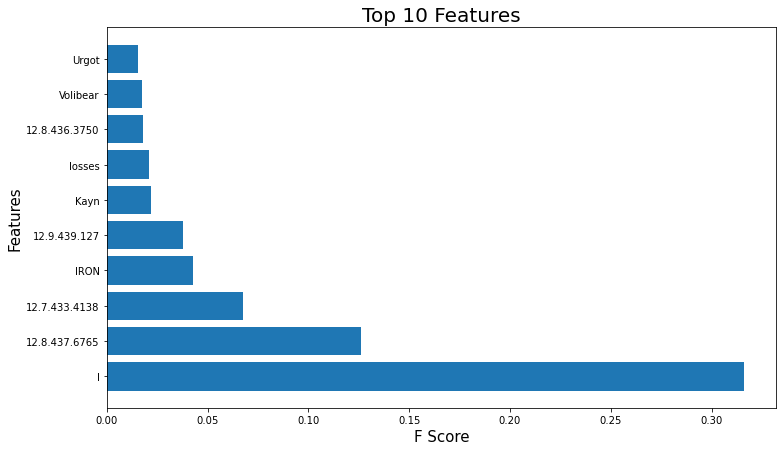

In [24]:
#plot top 10 features
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

feature_names = transformed_X.columns

# Get the names of each feature
new_list = []
for feature in feature_names:
    if re.match(r"remainder__x\d_", feature):
        feature = re.sub(r"remainder__x\d_", '', feature)
    elif re.match(r"categ__x\d_", feature):
        feature = re.sub(r"categ__x\d_", '', feature)
    new_list.append(feature)
transformed_X.columns = new_list

sorted_idx = xgb_clf.feature_importances_.argsort()[::-1]
plt.barh(transformed_X.columns[sorted_idx][:10], xgb_clf.feature_importances_[sorted_idx][:10])
ax.set_title("Top 10 Features", fontsize=20)
ax.set_ylabel("Features", fontsize=15)
ax.set_xlabel("F Score", fontsize=15);

In [169]:
#save figure into png file 
fig.savefig("../reports/figures/feature_importance_fscore.png")

Interestingly enough, Rank I is the most important feature using the built-in feature_importances method. Along with rank, patch version seems to be significant too. This could be due to many factors which I assume caused these to be important in the model:

1. Rank I is the lowest rank in any tier, therefore retention rate of summoners playing ranked league of legends is much lower in the lowest ranks of any tier.

2. Patch version 12.8 (any game version with 12.8.XXX.XXXX) introduced many buffs throughout common oppressive champions such as Kassadin, Mordekaiser, Poppy. 

3. Just like rank I, IRON is the lowest of the lows when it comes to tiers. Iron was actually introduced much later in the game around season 2019-2021 when Riot decided Bronze was not enough of a base skill floor for players the lowest tier was shifted from Bronze to Iron.

I would like to now use SHAP values to compare feature importances with the internal method.

#### Shapley Values

SHAP package allows us to compute feature importance for the xgb classifier. It is model agnostic (meaning it works with any model!) and uses shapley values from game theory to esimate how does each feature contribute to the prediction.

In [183]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(transformed_X)

In [223]:
shap_values

array([[ 1.8731610e-01,  4.9819180e-05, -5.9883794e-05, ...,
        -1.0658784e-03, -5.6395188e-02, -8.0595195e-02],
       [ 1.8522911e-01,  1.5807389e-04, -3.5052944e-05, ...,
         2.0814401e-03, -4.7980364e-02, -8.0257259e-02],
       [ 1.9731671e-01, -1.3548930e-04, -1.9132478e-04, ...,
        -9.8597596e-04,  8.2082093e-02, -9.3099527e-02],
       ...,
       [ 1.8614189e-01,  3.4030483e-05, -3.6789486e-05, ...,
        -1.1914853e-03, -5.6162044e-02, -8.6211354e-02],
       [ 1.8462767e-01,  3.4941761e-05, -3.2033517e-05, ...,
         1.3201421e-03, -5.5502512e-02, -8.6356379e-02],
       [ 1.9623569e-01, -1.5896122e-04, -3.6940626e-05, ...,
        -7.6259510e-04, -5.1513501e-02, -8.0656543e-02]], dtype=float32)

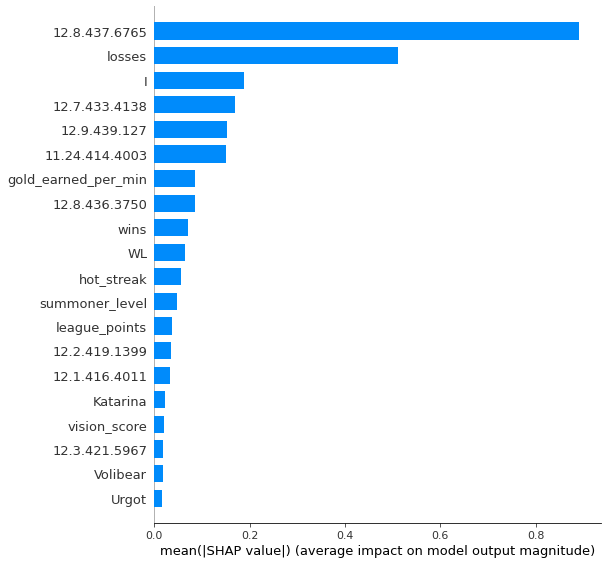

In [224]:
#plot top 20 features
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

shap.summary_plot(shap_values, transformed_X, plot_type="bar")

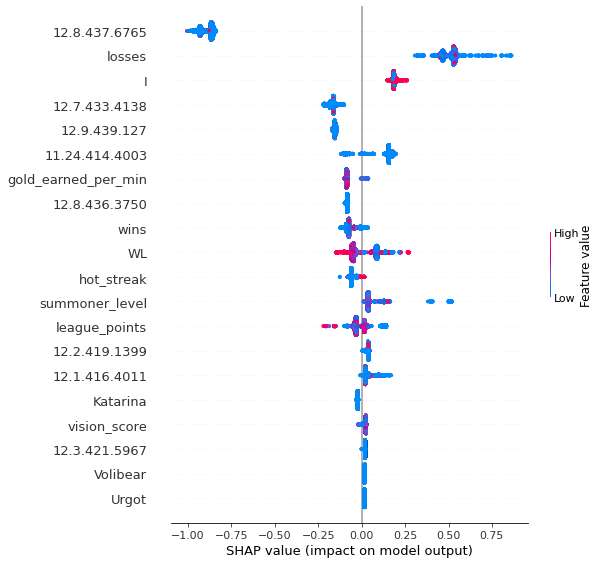

In [215]:
shap.summary_plot(shap_values, transformed_X)

In [171]:
#save figure into png file 
fig.savefig("../reports/figures/feature_importance_SHAP.png")

Compared to the previous feature importances game version 12.8 seems to be the most important feature. Losses actually jumped in importance when computing SHAP as well. A summoner that loses more often has more probability to churn. Losing in any game could make the experience unenjoyable and therefore you quit playing that game.

To prove these assumptions I need to implement partial dependency plots. Partial dependence plots are a great way (though not the only way) to extract insights from complex models. These can be incredibly powerful for communicating those insights to colleagues or non-technical users.

#### Partial Dependency Plots

We need to refit the model once again on the original data in order to get our PDP. The reason for this is because PDPs are not friendly with categorical features. It requires the exact name and count from the original data in order to find the partial dependence of that feature to the target variable. Therefore I created a new X based off the old one and I passed the column transformer onto X to get all the features I need for the PDP.

In [25]:
new_X = pd.DataFrame(ct.fit_transform(X).toarray())
new_X.columns = pipeline.named_steps['columntransformer'].get_feature_names()

# Get the names of each feature
new_list = []
for feature in new_X.columns:
    if re.match(r"remainder__x\d_", feature):
        feature = re.sub(r"remainder__x\d_", '', feature)
    elif re.match(r"categ__x\d_", feature):
        feature = re.sub(r"categ__x\d_", '', feature)
    new_list.append(feature)
new_X.columns = new_list

new_X

,I,II,III,IV,BRONZE,CHALLENGER,DIAMOND,GOLD,IRON,MASTER,PLATINUM,SILVER,10.25.348.1797,10.25.350.1724,11.1.351.8352,11.1.352.5559,11.10.374.9538,11.10.376.4811,11.11.377.6311,11.12.379.4946,11.13.382.1241,11.14.384.6677,11.14.385.9967,11.15.387.5736,11.15.388.2387,11.15.389.2308,11.16.390.1945,11.17.393.607,11.17.394.4489,11.18.395.7538,11.19.398.2521,11.19.398.9466,11.2.353.8505,11.20.400.7328,11.21.403.3002,11.22.406.3587,11.23.409.111,11.24.412.2185,11.24.413.2485,11.24.414.4003,11.3.356.7268,11.3.357.5376,11.4.358.8046,11.4.360.513,11.5.361.3108,11.6.364.2723,11.6.365.1420,11.7.366.7612,11.8.369.4139,11.8.370.4668,11.9.372.2066,12.1.414.6260,12.1.416.4011,12.2.418.8114,12.2.419.1399,12.3.420.4308,12.3.421.3734,12.3.421.5967,12.4.423.2790,12.5.425.9171,12.6.430.6775,12.6.431.7988,12.6.432.1258,12.7.433.4138,12.8.436.3750,12.8.437.6765,12.9.439.127,BOTTOM,JUNGLE,MIDDLE,NONE,TOP,Aatrox,Ahri,Akali,Akshan,Alistar,Amumu,Anivia,Annie,Aphelios,Ashe,AurelionSol,Azir,Bard,Blitzcrank,Brand,Braum,Caitlyn,Camille,Cassiopeia,Chogath,Corki,Darius,Diana,DrMundo,Draven,Ekko,Elise,Evelynn,...,Morgana,Nami,Nasus,Nautilus,Neeko,Nidalee,Nocturne,Nunu,Olaf,Orianna,Ornn,Pantheon,Poppy,Pyke,Qiyana,Quinn,Rakan,Rammus,RekSai,Rell,Renata,Renekton,Rengar,Riven,Rumble,Ryze,Samira,Sejuani,Senna,Seraphine,Sett,Shaco,Shen,Shyvana,Singed,Sion,Sivir,Skarner,Sona,Soraka,Swain,Sylas,Syndra,TahmKench,Taliyah,Talon,Taric,Teemo,Thresh,Tristana,Trundle,Tryndamere,TwistedFate,Twitch,Udyr,Urgot,Varus,Vayne,Veigar,Velkoz,Vex,Vi,Viego,Viktor,Vladimir,Volibear,Warwick,Xayah,Xerath,XinZhao,Yasuo,Yone,Yorick,Yuumi,Zac,Zed,Zeri,Ziggs,Zilean,Zoe,Zyra,league_points,wins,losses,veteran,fresh_blood,hot_streak,assists,kills,deaths,gold_earned,turret_kills,total_dmg_dealt,total_heal,vision_score,summoner_level,time_played,KDA,WL,gold_earned_per_min
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0.0,0.0,0.0,14.0,6.0,8.0,14003.0,0.0,178703.0,7305.0,26.0,212.0,2456.0,2.500000,0.272727,0.095026
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0.0,0.0,0.0,5.0,7.0,6.0,11613.0,1.0,115684.0,5374.0,17.0,211.0,1993.0,2.000000,0.272727,0.097115
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [26]:
new_X.shape

(33710, 250)

In [27]:
y.shape

(33710,)

In [28]:
#refitting XGBClassifier in order to show PDP
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.2, train_size=0.8)

xgb_clf_2 = xgb.XGBClassifier(max_depth=20, learning_rate=0.00719580052831331, n_estimators=198)

xgb_clf_2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.00719580052831331, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=20, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=198, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)

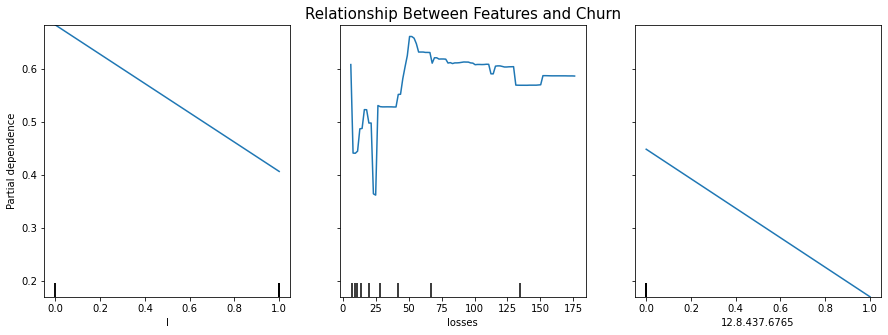

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title('Relationship Between Features and Churn', fontsize=15)
PartialDependenceDisplay.from_estimator(xgb_clf_2, X_train, features=['I', 'losses',
                                                                    '12.8.437.6765'], ax=ax);

In [30]:
#save figure into png file 
fig.savefig("../reports/figures/partial_dependence_plot.png")

The Partial Dependency Plots show negative linear relationships amongst the several inputs vs. the target variable. This means that churn depends linearly on rank I, and patch 12.8.437.6765. For losses though it's much harder to interpret, but overall even though the relationship is not linear it leans towards negative correlation as the amount of losses increase. The probability that a summoner churns decreases when a summoner is categorized in either of these features.

Could it be that lower ranked players are actually less likely to quit the game? My original assumptions were that lower leveled/lower skilled players were more likely to give up the game after some frustration. Also another interesting one is that patch 12.8 which introduced many buffs/nerfs to the game seemed to have a huge impact on the predictions.

We've seen that it is possible to predict whether a ranked League of Legends player will churn or not, based only on the gameplay data of that player's first match!